In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from datasplit import DataSplit
from preprocess import DataPreprocessor
from candidate_model import CandidateModel
from metrics import recall_at_k, calc_mean_metric

## load & split

In [24]:
purchases = pd.read_csv('retail_train.csv')

# train/valid split
splitter = DataSplit(purchases, 'week_no', [6, 3])

train_lv1 = purchases[splitter.part0].copy()
valid_lv1 = purchases[splitter.part1].copy()
train_lv2 = purchases[splitter.part1].copy()
valid_lv2 = purchases[splitter.part2].copy()

# prepare true values for validation
true_values = valid_lv1.groupby('user_id')['item_id'].unique().reset_index()
true_values.columns=['user_id', 'actual']

## prepare data

In [25]:
mix_feat_params = {
    'top_config': {'fields': ['quantity', 'sales_value'],
                   'beta': [1., 1.],
                   'k': 5000,
                   'scaler': StandardScaler
                    },
    'uim_config': {'aggfunc': 'sum', },
}

pre = DataPreprocessor(train_lv1, valid_lv1, **mix_feat_params)
pre.fit()

## research candidate models

In [27]:
candidate_params = {
    'train': pre.train_uim_sparse,
    'weighted': pre.train_uim_weighted,
    'top_items': pre.top_k_items,
    'placeholder_id': pre.placeholder_id,
    'idx_to_item': pre.idx_to_item,
    'item_to_idx': pre.item_to_idx,
    'user_to_idx': pre.user_to_idx
}

### K nearest users

In [45]:
%%time
# research candidate models: K-nearest users
k_users_array = np.array([1, 2, 3, 5, 10, 20, 50])
pred_size = 100

metrics = pd.DataFrame(columns=k_users_array.astype(str))
for k in k_users_array:
    predicts = pd.DataFrame()
    for model_name in ('ItemItem', 'Cosine', 'TFIDF', 'BM25'):
        cm = CandidateModel(model_name, **candidate_params)
        cm.fit(K=k)     # nearest K users recommender
        predicts[model_name] = cm.predict(true_values['user_id'], N=pred_size)
    metrics[str(k)] = calc_mean_metric(recall_at_k, true_values['actual'], predicts, k=pred_size)
# ALS has no K-users parameter => it will be the same metric for any K
cm = CandidateModel('ALS', **candidate_params)
cm.fit()
als_predicts = cm.predict(true_values['user_id'], N=pred_size)
als_metric = calc_mean_metric(recall_at_k, true_values['actual'], als_predicts, k=pred_size)
# top-K metric
top_k_metric = true_values['actual'].apply(lambda tr_val: recall_at_k(tr_val, pre.top_k_items[:pred_size], k=pred_size)).mean()

CPU times: user 5min 47s, sys: 1min 32s, total: 7min 19s
Wall time: 3min 36s


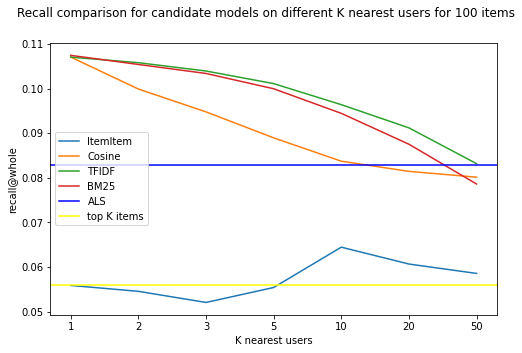

In [46]:
# recall on K nearest users
plt.figure(figsize=(8, 5))
plt.suptitle(f'Recall comparison for candidate models on different K nearest users for {pred_size} items')
plt.xlabel('K nearest users')
plt.ylabel('recall@whole')
plt.plot(metrics.T)
plt.axhline(als_metric, color='blue')
plt.axhline(top_k_metric, color='yellow')
plt.legend(labels=[*metrics.index, 'ALS', 'top K items']);
plt.savefig(f'recall_K_nearest_users({pred_size}_items).png')

### Number of candidates

In [34]:
%%time
# research candidate models: K nearest items
k_array = np.array([20, 50, 100, 200, 500])
metrics = pd.DataFrame(columns=k_array.astype(str))

for model_name in ('ItemItem', 'Cosine', 'TFIDF', 'BM25', 'ALS'):
    cm = CandidateModel(model_name, **candidate_params)
    if model_name == 'ALS':
        cm.fit()
    else:
        cm.fit(K=1)     # own recommender
        # cm.fit(K=2)     # nearest user recommender
        # cm.fit(K=10)     # nearest 10 users recommender
    for k in k_array:
        predicts = cm.predict(true_values['user_id'], N=k)
        metrics.loc[model_name, str(k)] = calc_mean_metric(recall_at_k, true_values['actual'], predicts, k=k)
        # top-K metric
        metrics.loc['top K items', str(k)] = true_values['actual'].apply(lambda tv: recall_at_k(tv, pre.top_k_items[:k], k=k)).mean()

CPU times: user 21min 22s, sys: 7min 49s, total: 29min 11s
Wall time: 14min 16s


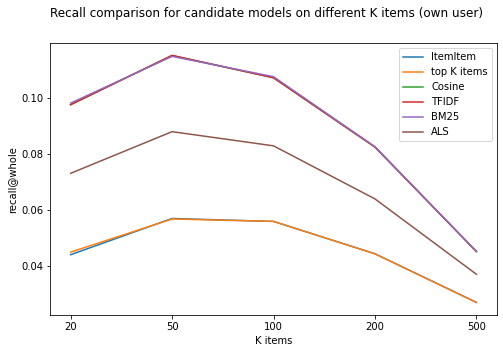

In [35]:
plt.figure(figsize=(8, 5))
plt.suptitle('Recall comparison for candidate models on different K items (own user)')
plt.xlabel('K items')
plt.ylabel('recall@whole')
plt.plot(metrics.T)
plt.legend(labels=metrics.index);
plt.savefig('recall_K_nearest_items(own_recommender).png')
# plt.savefig('recall_K_nearest_items(nearest_user_recommender).png')
# plt.savefig('recall_K_nearest_items(10_nearest_users_recommender).png')

### TFIDF own recommender

In [43]:
%%time
metrics = []
n_candidates = np.arange(35, 76, 5)
candidate_params = {
    'train': pre.train_uim_sparse,
    'weighted': pre.train_uim_weighted,
    'top_items': pre.top_k_items,
    'placeholder_id': pre.placeholder_id,
    'idx_to_item': pre.idx_to_item,
    'item_to_idx': pre.item_to_idx,
    'user_to_idx': pre.user_to_idx
}
cm = CandidateModel('TFIDF', **candidate_params)
cm.fit(K=1)     # TFIDF own recommender
for n in n_candidates:
    predicts = cm.predict(true_values['user_id'], N=n)
    metrics.append(calc_mean_metric(recall_at_k, true_values['actual'], predicts, k=n))

CPU times: user 29.8 s, sys: 0 ns, total: 29.8 s
Wall time: 28.6 s


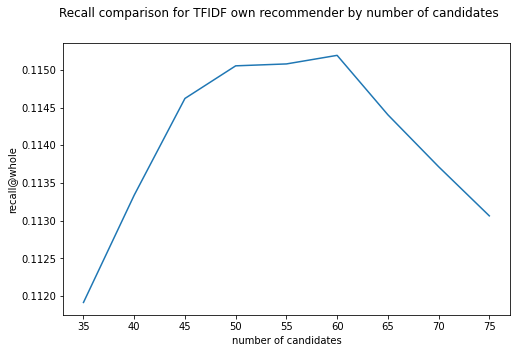

In [44]:
plt.figure(figsize=(8, 5))
plt.suptitle('Recall comparison for TFIDF own recommender by number of candidates')
plt.xlabel('number of candidates')
plt.ylabel('recall@whole')
plt.plot(n_candidates, metrics)
plt.savefig('recall_TFIDF(own_recommender).png')

## conclusion

In [18]:
#